In [134]:
%pylab inline
%load_ext line_profiler

import pandas as pd
from pyvirchow.io import WSIReader
from pyvirchow.morphology import TissuePatch
from matplotlib.patches import Polygon

from shapely.geometry import Point as shapelyPoint

from pyvirchow.io.operations import get_annotation_bounding_boxes, get_annotation_polygons, translate_and_scale_object
from pyvirchow.io.operations import translate_and_scale_polygon
from openslide.deepzoom import DeepZoomGenerator
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os
import glob
from skimage.filters import threshold_otsu
from shapely.geometry import Polygon as shapelyPolygon
import openslide

from tqdm import tqdm_notebook

from pyvirchow.io.operations import get_annotation_bounding_boxes, get_annotation_polygons, \
    poly2mask, translate_and_scale_polygon, read_as_rgb

from pyvirchow.morphology.patch_extractor import TissuePatch
from pyvirchow.morphology.mask import mpl_polygon_to_shapely_scaled, get_common_interior_polygons

Populating the interactive namespace from numpy and matplotlib
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
tumor = WSIReader('../../../histopath_data/CAMELYON16/training/tumor/tumor_009.tif', 40)

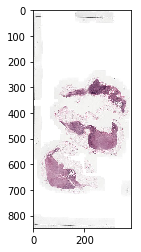

In [3]:
plt.imshow(tumor.get_thumbnail((tumor.width/256, tumor.height/256)))

In [14]:

#tiles_truth = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)


tiles = DeepZoomGenerator(tumor, tile_size=256, overlap=0, limit_bounds=False)
img = tiles.get_tile(tiles.level_count-1, (264, 141))

In [15]:
tiles.level_dimensions

((1, 1),
 (1, 2),
 (2, 4),
 (3, 7),
 (6, 14),
 (12, 27),
 (24, 53),
 (48, 106),
 (96, 212),
 (191, 424),
 (382, 848),
 (764, 1696),
 (1528, 3392),
 (3056, 6784),
 (6112, 13568),
 (12224, 27136),
 (24448, 54272),
 (48896, 108544),
 (97792, 217088))

In [16]:
tiles.get_tile_coordinates(tiles.level_count-1, (112, 343))

((28672, 87808), 0, (256, 256))

In [17]:
def plot_img(x=150, y=420):
    img = tiles.get_tile(tiles.level_count-1, (x, y))
    plt.imshow(img)

In [104]:
def check_patch_coordinates_state(json_filepath, x_min, y_min, patchsize, boxes=None, polygons=None):   
    if boxes is None:
        boxes = get_annotation_bounding_boxes(json_filepath)
    if polygons is None:
        polygons = get_annotation_polygons(json_filepath)

    
       
    x_right = x_min + patchsize
    y_bottom = y_min + patchsize
    
    patch_polygon = shapelyPolygon(
                        [(x_min, y_min), (x_right, y_min),
                         (x_right, y_bottom), (x_min, y_bottom)]).buffer(0)
    
    #array = np.array([(x_min, y_min), (x_right, y_min),
    #                    (x_right, y_bottom), (x_min, y_bottom)])
    array = np.array([(x_min, y_min)])
   
    """
    is_in_tumor = get_common_interior_polygons(patch_polygon, polygons['tumor'])
    is_in_normal = get_common_interior_polygons(patch_polygon, polygons['normal'])
    patch_polygon = Polygon(array)
    """
    
    """
    is_in_normal = []
    is_in_tumor = []
    for index, polygon in enumerate(polygons['normal']):
        if polygon.get_path().contains_points(array).all():
            is_in_normal.append(index)
    for index, polygon in enumerate(polygons['tumor']):
        if polygon.get_path().contains_points(array).all():
            is_in_tumor.append(index)
    """
    
    is_in_normal = []
    is_in_tumor = []
    for index, rectangle in enumerate(boxes['normal']):
        rect_xmin, rect_ymin  = rectangle['top_left']
        rect_xmax, rect_ymax = rectangle['bottom_right']
        if x_min in range(rect_xmin, rect_xmax) and y_min in range(rect_ymin, rect_ymax):
            is_in_normal.append(index)
    
    for index, rectangle in enumerate(boxes['tumor']):
        rect_xmin, rect_ymin  = rectangle['top_left']
        rect_xmax, rect_ymax = rectangle['bottom_right']
        if x_min in range(rect_xmin, rect_xmax) and y_min in range(rect_ymin, rect_ymax):
            is_in_tumor.append(index)
    
    
            
    if len(is_in_tumor) and len(is_in_normal):
        print('both')
        polygons_to_exclude = {'tumor': [], 'normal': []}

        for polygon in polygons['tumor']:
            # Does this have any of the normal polygons inside it?
            polygons_to_exclude['tumor'].append(
                get_common_interior_polygons(polygon, polygons['normal']))

        for polygon in polygons['normal']:
            # Does this have any of the tumor polygons inside it?
            polygons_to_exclude['normal'].append(
                get_common_interior_polygons(polygon, polygons['tumor']))

        normal_inside_tumor = polygons_to_exclude['tumor'][is_in_tumor[0]]
        if normal_inside_tumor:
            return 'normal'
        else:
            return 'tumor'
    
    if len(is_in_tumor):
        return 'tumor'
        #print(polygons['tumor'][0].get_xy().min(axis=0), polygons['tumor'][0].get_xy().max(axis=0), x_min, y_min, 'tumor')
    #print(polygons['tumor'][0].get_xy().min(axis=0), polygons['tumor'][0].get_xy().max(axis=0), x_min, y_min, 'normal')        
    
    return 'normal'

 


In [68]:
json_filepath = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_110.json'

In [28]:
(xmin, ymin) , level, patchsize = tiles.get_tile_coordinates(tiles.level_count-1, (112, 343))

In [29]:
check_patch_coordinates_state(json_filepath, 30683, 19068, patchsize[0])   

'tumor'

In [145]:
def find_patches_from_slide(slide_path, polygons, add_tumor_patches=True, filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    """
    slide_contains_tumor = False#'tumor' in os.path.basename(slide_path)
    
    with openslide.open_slide(slide_path) as slide:
        thumbnail = slide.get_thumbnail((int(slide.dimensions[0] / 256), int(slide.dimensions[1] / 256)))
        thumbnail_nrow = int(slide.dimensions[0] / 256)
        thumbnail_ncol = int(slide.dimensions[1] / 256)
    
    thumbnail_grey = np.array(thumbnail.convert('L')) # convert to grayscale
    
    thresh = threshold_otsu(thumbnail_grey)
    binary = thumbnail_grey > thresh
    
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches.loc[:, 'is_tissue'] = ~patches[0]
    patches.drop(0, axis=1, inplace=True)
    
    if add_tumor_patches:
        scaled_tumor_polygons = []
        #scaled_normal_polygons = []
        for tpol in polygons['tumor']:
            scaled = translate_and_scale_polygon(tpol, 0, 0, 1/256)
            scaled_tumor_polygons.append(scaled)
        polymasked = poly2mask(scaled_tumor_polygons, (thumbnail_nrow, thumbnail_ncol))
        # Is any of the masked out points inside a normal annotated region?
        poly_x, poly_y = np.where(polymasked > 0)
        set_to_zero = [] 
        
        for px, py in zip(poly_x, poly_y):
            point = shapelyPoint(px, py)
            for npol in polygons['normal']:
                scaled = translate_and_scale_polygon(npol, 0, 0, 1/256)
                pol = shapelyPolygon(scaled.get_xy())
                if pol.contains(point):
                    set_to_zero.append((px,py))
        
        if len(set_to_zero):
            set_to_zero = np.array(set_to_zero)
            polymasked[set_to_zero] = 0        
        print('set to zero: {}'.format(len(set_to_zero)))        
                
        patches_y = pd.DataFrame(pd.DataFrame(polymasked).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y.drop(0, axis=1, inplace=True)

        patches = pd.concat([patches, patches_y], axis=1)
        
    patches.loc[:, 'slide_path'] = slide_path    
    #patches.loc[:, 'is_tumor'] = False
    if filter_non_tissue:
        patches = patches[patches.is_tissue == True] # remove patches with no tissue
    patches['tile_loc'] = list(patches.index)
    patches.reset_index(inplace=True, drop=True)
    return patches



    
def get_tile_xy(tiles, xrow, ycol):
    (x,y), level, patchsize =  tiles.get_tile_coordinates(tiles.level_count-1, (xrow, ycol))
    return x,y,level,patchsize[0]

def get_tumor_status_from_tile_loc(slide_path, json_filepath, tile_loc, 
                                   boxes, polygons, patch_size=256):
    #with openslide.open_slide(slide_path) as slide:
    #    tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
    #x_min0, y_min0, level, patchsize = get_tile_xy(tiles, tile_loc[0], tile_loc[1])
    x_min = tile_loc[0] * patch_size
    y_min = tile_loc[1] * patch_size
    #assert x_min0 == x_min
    #assert y_min0 == y_min
    status = check_patch_coordinates_state(json_filepath, x_min, y_min, 
                                           patch_size, boxes, polygons)
    if status == 'tumor':
        return True
    return False
    

In [146]:
slide_path = '../../../histopath_data/CAMELYON16/training/tumor/tumor_110.tif'
json_filepath = '../../../histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_110.json'

boxes = get_annotation_bounding_boxes(json_filepath)
polygons = get_annotation_polygons(json_filepath)
samples = find_patches_from_slide(slide_path, polygons, add_tumor_patches=True, filter_non_tissue=True) 

set to zero: 33
     0
0 0  0
  1  0
  2  0
  3  0
  4  0


In [147]:
samples.head()

,is_tissue,is_tumor,slide_path,tile_loc
0,True,False,../../../histopath_data/CAMELYON16/training/tu...,"(3, 40)"
1,True,False,../../../histopath_data/CAMELYON16/training/tu...,"(4, 42)"
2,True,False,../../../histopath_data/CAMELYON16/training/tu...,"(4, 43)"
3,True,False,../../../histopath_data/CAMELYON16/training/tu...,"(4, 363)"
4,True,False,../../../histopath_data/CAMELYON16/training/tu...,"(20, 234)"


In [148]:
samples.is_tumor.value_counts()

False    17906
True     14064
Name: is_tumor, dtype: int64

In [ ]:
t